<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: 12 </center></h4>
<h4><center> Filename: assignment_1_12.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Chua Xin Xuan, A0205767X </center></h4>
<h4><center> Group Member 2: Joey Tan Xin Yi, A0206334N </center></h4>
<h4><center> Group Member 3: Quek Su Ning, A0205557A </center></h4>
<h4><center> Group Member 4: Tan Jie Yi, A0206383H </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



In [40]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp
import pylab as plt
import imageio
import os
import numpy as np
import cv2
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import time
import random


# Data Download
1. Download the "celeba_small.zip" file available on lumiNUS.
This is a 146Mo large zip-file containing 20K face images.
2. Download the attribute file "celeba.csv" available on lumiNUS.
3. Unzip the file "celeba_small.zip" in the directory of your choice. (Data = 175 Mo when uncompressed). 


# Brief Data exploration

In [4]:
path_csv  = "/Users/joeyt/Desktop/4212 lab/project"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))

In [5]:
#"attribute" is a dictionary containing several attributes for each image
attribute.keys()

Index(['Filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [6]:
#let us list all the files in the image directory
path = "/Users/joeyt/Desktop/4212 lab/project/img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


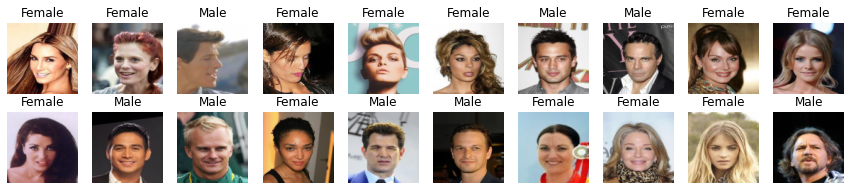

In [7]:
#let us display the first 20 images
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100 for display (you do not have to do this in the assignment)
    im = resize(im, (100,100) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")
    

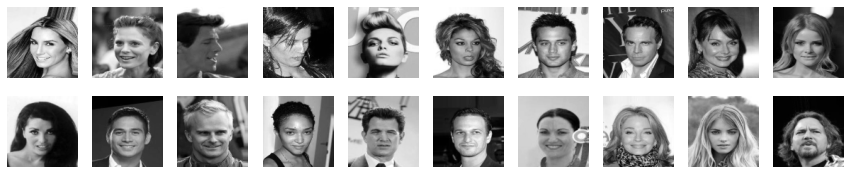

In [8]:
#let us display the first 20 images in black and white
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100
    im = resize(im, (100,100) )
    #transform to black and white by averaging the 3 color channels
    im = np.mean(im, axis=2)
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap="gray")
    plt.axis("off")

In [9]:
#let us load the first 500 images
n_img = 500
img_array = np.zeros((n_img, 100,100))
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    im = np.mean(im, axis=2) # average the last channel
    img_array[k,:,:] = im

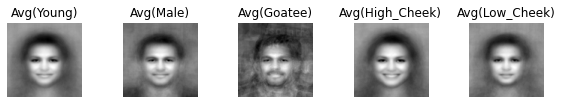

In [10]:
#let us plot a few "average" faces
plt.figure(figsize=(10,3))

plt.subplot(2,5,1)
is_young = attribute["Young"][:n_img]==1
plt.imshow(np.mean(img_array[is_young,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Young)")

plt.subplot(2,5,2)
is_male = attribute["Male"][:n_img]==1
plt.imshow(np.mean(img_array[is_male,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Male)")


plt.subplot(2,5,3)
is_Goatee = attribute["Goatee"][:n_img]==1
plt.imshow(np.mean(img_array[is_Goatee,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Goatee)")


plt.subplot(2,5,4)
is_High_Cheekbones = attribute["High_Cheekbones"][:n_img]==1
plt.imshow(np.mean(img_array[is_High_Cheekbones,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(High_Cheek)")


plt.subplot(2,5,5)
is_Low_Cheekbones = attribute["High_Cheekbones"][:n_img]==-1
plt.imshow(np.mean(img_array[is_Low_Cheekbones,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Low_Cheek)")

#
#  FIGURE EXPORT:
#
# To export figures to include in the pdf report, you can use the 
# following command, making sure that dpi is high enough in order
# to export a figure with reasonable quality
plt.savefig("high_quality_export.png", dpi=300)

In [11]:
# let us compute the proportion of male images
proportion_male = np.mean(attribute["Male"].values==1)
print(f"Proportion of Young people in the dataset: {100*proportion_male: .1f} %",  )

Proportion of Young people in the dataset:  42.2 %




# General Remarks

Your assignment consists in building an algorithm that can automatically tell whether an image corresponds to a Male or Female. 

1. You are only allowed to use (variants of) logistic regression models (possibly with regularization + feature engineering). In othe words, do not use deep-learning / convolutional-layers / etc.., that is not the purpose of this assignment
2. You can only use the first 15,000 images to train your models (note that you do not have to use all the 15,000 first images if you do not want to). The accuracy of your model will be evaluated on the last 5,000 images. The last 5,000 images constitute the test set.
3. You are allowed to use whatever optimization algorithm you think is most efficient.
4. You are allowed to do whatever pre-processing and feature engineering you deem appropriate.
5. You will report the accuracy (i.e. th percentage of correctly classified) on the test dataset (i.e. the last 5,000 images). 
6. You will as well report the Area Under the Curve (AUC) of your classifier on the test dataset.


# Specific Tasks
1. How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? Is it necessary to use all the training set, or does the accuracy stabilize before?
2. How does the accuracy depend on the resolution of the input image?
3. Is it necessary to use colored images (or black & white images are enough)? Is it helpful to increase the contrast of the images? Other preprocessing ideas?
4. What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..
5. Is it useful to use an ensemble of models (eg. for example, you can use a different model for each part of the face, and then try to find a way to ensemble these models)?
6. Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)
7. Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).


# Last Remark
A. Your code needs to be readable and **reproducible**. Make sure that it is possible to run the notebook to reproduce all the results presented in the pdf report. 
B. You need to submit two files: (1) a jupyter notebook with your code (2) a pdf report explaining your approaches and conclusions.  
C. Your report pdf report does not need to be long. It needs to describe the experiments that you have carried out, briefly detail the algorithms that you have used, include a few figures and outline the conclusions of your investigations. You can have a look at these (very good) machine-learning papers available [here](https://nips.cc/Conferences/2021/DatasetsBenchmarks/AcceptedPapers) although (indeed!) your report definitely does not need to be as long as these articles.  
D. You need to acknowledge carefully all the sources that you have used. 

# X_train X_test (BW)

In [12]:
#load the 15000 images - train dataset
n_train = 15000
X_train_bw = np.zeros((n_train, 100,100))
for k in range(n_train):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    im = np.mean(im, axis=2) # average the last channel
    X_train_bw[k,:,:] = im

In [13]:
n_val = 5000
X_test_bw = np.zeros((n_val, 100, 100))
for k in range(15000, 15000 + n_val): 
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    im = np.mean(im, axis=2) 
    X_test_bw[k - 15000,:,:] = im

In [14]:
X_train_bw = X_train_bw.reshape(15000, 100*100)
X_test_bw = X_test_bw.reshape(5000, 100*100)

# X_train X_test (RGB)

In [16]:
n_img = 15000
X_train_rgb = np.zeros((n_img, 100,100,3))
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    X_train_rgb[k,:,:,:] = im

In [17]:
n_img = 5000
X_test_rgb = np.zeros((n_img, 100,100,3))
for k in range(15000,20000):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    X_test_rgb[k-15000,:,:,:] = im

In [18]:
X_train_rgb = X_train_rgb.reshape(15000, 100*100*3)
X_test_rgb = X_test_rgb.reshape(5000, 100*100*3)

# Y response

In [15]:
Y_train = np.asarray(attribute["Male"][0:15000])

In [16]:
Y_test = np.asarray(attribute["Male"][15000:20000])

# Logistic Regression 

In [17]:
def prediction(beta, x):
    """
    desc:
    =====
    compute the probability that x is associated to a +1 label

    args:
    ====
     x: vector of dimension 784
     beta: vector of dimension 784 (logistic reg param)     
    """
    proba = 1. / (1. + jnp.exp(-jnp.dot(x,beta)))
    return proba

# let us parallelize the function:
# beta: no parallelization
# x: parallelization along the axis 0
prediction_batch = jax.vmap(prediction, in_axes=(None, 0))

In [18]:
@jax.jit
def compute_error_rate(beta, X, Y):
    # compute predictions (True or False)
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return jnp.mean(Y == pred)

# typo!!
# this is the accuracy 

In [19]:
@jax.jit # makes things faster, compiles the function, when run function again, it will compute much faster
def loss_single(beta, x, y):
    """
    desc:
    =====
    compute the logistic regression loss for a single image

    args:
    ====
     beta: vector of dimension 784 (logistic reg param)
     x: vector of dimension 784
     y: {+1, -1} label
    """
    return jnp.log(1. + jnp.exp(-y * jnp.dot(x, beta)))

In [20]:
loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0)) 

In [21]:
@jax.jit
def loss(beta, X, Y):
    """
    description:
    ====
     logistic regression loss
     ====
     args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    loss_individuals = loss_all(beta, X, Y)
    
    # return the average loss
    return jnp.mean(loss_individuals)

# let us compute the gradient and compile
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) ) # argnums=0, compute gradient wrt first argument (beta)

In [22]:
# parameter of the logistic regression
np.random.seed(1)
beta_init_bw = np.random.normal(0,scale=1/np.sqrt(100*100),size=(100*100))

In [23]:
# parameter of the logistic regression
np.random.seed(1)
beta_init_rgb = np.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))

## Naive Gradient Descent with Automatic Step Size Selection

### Black and White Images

In [24]:
n_iter = 20000
learning_rate = 1
alpha = 0.5
history = []
history_learning_rate = []
train_acc=[]
test_acc=[]
beta=np.copy(beta_init_bw)

start_time=time.time()
for k in range(n_iter):
    v,g = loss_value_and_grad(beta, X_train_bw, Y_train)
    gradient = g
    desc = -gradient # descent direction
    
    # automatically choose the learning rate
    learning_rate = 3*learning_rate # make the learning rate a bit bigger
    while loss_value_and_grad(beta+learning_rate*desc, X_train_bw, Y_train)[0]> loss_value_and_grad(beta, X_train_bw, Y_train)[0] + alpha*learning_rate*np.dot(desc, gradient):
        # while condition not satisfied, divide the learning rate by two
        learning_rate = 0.5 * learning_rate
    
    beta = beta + learning_rate * desc
    history.append(v)
    history_learning_rate.append(learning_rate)
    if k % 1 == 0:
        err_train = 100*compute_error_rate(beta, X_train_bw, Y_train)
        train_acc.append(err_train)
        err_val= 100*compute_error_rate(beta, X_test_bw, Y_test)   
        test_acc.append(err_val)
        print(f"iter:{k} \t Loss:{v:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
        # typo!!
        # error(train) should be accuracy(train)
        # error(val) should be accuracy(val)
end_time=time.time()

iter:0 	 Loss:71.082 	 error(train):45.5% 	 error(val):43.8%
iter:1 	 Loss:24.595 	 error(train):47.8% 	 error(val):45.7%
iter:2 	 Loss:22.864 	 error(train):49.2% 	 error(val):47.7%
iter:3 	 Loss:22.363 	 error(train):50.1% 	 error(val):49.0%
iter:4 	 Loss:21.837 	 error(train):48.8% 	 error(val):47.2%
iter:5 	 Loss:21.184 	 error(train):50.9% 	 error(val):49.8%
iter:6 	 Loss:20.826 	 error(train):49.5% 	 error(val):47.8%
iter:7 	 Loss:20.462 	 error(train):51.3% 	 error(val):50.3%
iter:8 	 Loss:20.145 	 error(train):50.6% 	 error(val):48.9%
iter:9 	 Loss:19.886 	 error(train):51.8% 	 error(val):50.7%
iter:10 	 Loss:19.321 	 error(train):50.9% 	 error(val):49.2%
iter:11 	 Loss:19.052 	 error(train):52.1% 	 error(val):50.7%
iter:12 	 Loss:18.747 	 error(train):51.1% 	 error(val):49.5%
iter:13 	 Loss:18.495 	 error(train):52.6% 	 error(val):51.5%
iter:14 	 Loss:18.199 	 error(train):51.9% 	 error(val):50.3%
iter:15 	 Loss:18.001 	 error(train):51.9% 	 error(val):50.8%
iter:16 	 Loss:17.

In [25]:
100*compute_error_rate(beta, X_train_bw, Y_train) #train accuracy

DeviceArray(88.25333333, dtype=float64)

In [26]:
100*compute_error_rate(beta, X_test_bw, Y_test) #test accuracy

DeviceArray(85.6, dtype=float64)

In [27]:
end_time-start_time

8983.98002409935

#### Loss Graph

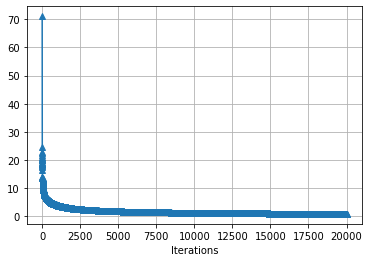

In [28]:
plt.plot(history, "-^")
plt.xlabel("Iterations")
plt.grid(True)

#### ROC Curve (AUC)

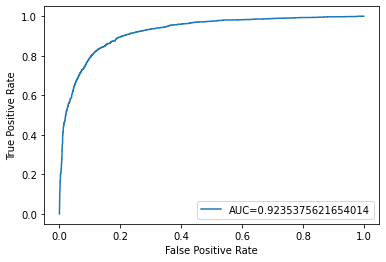

In [29]:
y_pred_proba = prediction_batch(beta,X_test_bw)
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)


plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Stochastic Gradient Descent

### Black and White Images

In [30]:
n_epoch = 1500
minibatch_size = 5 #size of the minibatchs
N = len(X_train_bw)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init_bw)
learning_rate = 0.000000005

train_acc=[]
test_acc=[]

start_time=time.time()
for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_bw[batch_indices]
        Y_minibatch = Y_train[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    
    if epoch % 100 == 0:
        err_train = 100*compute_error_rate(beta, X_train_bw, Y_train)
        train_acc.append(err_train)
        err_val= 100*compute_error_rate(beta, X_test_bw, Y_test)
        test_acc.append(err_val)
        print(f"epoch:{epoch} \t Loss:{np.mean(all_loss_within_epoch):2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
        # typo!!
        # error(train) should be accuracy(train)
        # error(val) should be accuracy(val)
end_time=time.time()

epoch:0 	 Loss:23.880 	 error(train):51.4% 	 error(val):50.3%
epoch:100 	 Loss:4.168 	 error(train):72.6% 	 error(val):73.2%
epoch:200 	 Loss:2.913 	 error(train):77.6% 	 error(val):77.8%
epoch:300 	 Loss:2.351 	 error(train):80.2% 	 error(val):80.0%
epoch:400 	 Loss:2.027 	 error(train):82.1% 	 error(val):81.6%
epoch:500 	 Loss:1.808 	 error(train):83.3% 	 error(val):82.6%
epoch:600 	 Loss:1.646 	 error(train):84.0% 	 error(val):83.5%
epoch:700 	 Loss:1.521 	 error(train):84.7% 	 error(val):83.9%
epoch:800 	 Loss:1.419 	 error(train):85.5% 	 error(val):84.2%
epoch:900 	 Loss:1.333 	 error(train):85.6% 	 error(val):84.3%
epoch:1000 	 Loss:1.260 	 error(train):86.1% 	 error(val):84.6%
epoch:1100 	 Loss:1.199 	 error(train):86.5% 	 error(val):84.7%
epoch:1200 	 Loss:1.143 	 error(train):86.7% 	 error(val):84.8%
epoch:1300 	 Loss:1.093 	 error(train):87.0% 	 error(val):85.2%
epoch:1400 	 Loss:1.048 	 error(train):87.4% 	 error(val):85.3%


In [31]:
100*compute_error_rate(beta, X_train_bw, Y_train) #train accuracy

DeviceArray(87.58666667, dtype=float64)

In [32]:
100*compute_error_rate(beta, X_test_bw, Y_test) #test accuracy

DeviceArray(85.36, dtype=float64)

In [33]:
end_time-start_time

1204.2509820461273

#### Loss Function

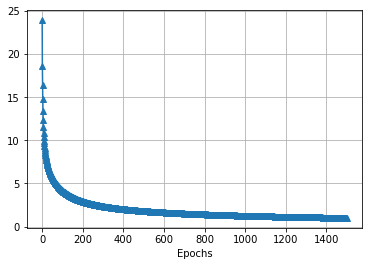

In [34]:
plt.plot(loss_history_end_epoch, "-^")
plt.xlabel("Epochs")
plt.grid(True)

#### ROC Curve (AUC)

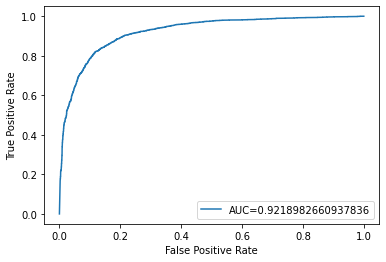

In [35]:
y_pred_proba = prediction_batch(beta,X_test_bw)
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Specific Task 1 : Impact of Different Train Sizes 

## Black and White Images

In [70]:
test_error={}
# typo!!
# this dictionary stores the test accuracy

for i in range(1000,15001,1000):
    n_epoch = 1500
    minibatch_size = 5 
    N = i 
    img_indices = np.arange(N)
    beta = np.copy(beta_init_bw)
    learning_rate = 0.000000005
    indices=random.sample(range(0,15000),i)
    train_set=X_train_bw[indices]
    train_res=Y_train[indices]
    for epoch in range(n_epoch):
        n_minibatch = N // minibatch_size + 1
        np.random.shuffle(img_indices)
        for k in range(n_minibatch):
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_set[batch_indices]
            Y_minibatch = train_res[batch_indices]

            val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

            beta = beta - learning_rate*grad
    
        if epoch % 100 == 0:
            err_val= 100*compute_error_rate(beta, X_test_bw, Y_test)
            if i in test_error:
                test_error[i].append(err_val)
            else:
                test_error[i]=[err_val]
            print(f"epoch:{epoch} \t error(val):{err_val:2.1f}%")

epoch:0 	 error(val):41.4%
epoch:100 	 error(val):57.3%
epoch:200 	 error(val):62.3%
epoch:300 	 error(val):64.7%
epoch:400 	 error(val):65.7%
epoch:500 	 error(val):65.9%
epoch:600 	 error(val):66.8%
epoch:700 	 error(val):67.1%
epoch:800 	 error(val):67.4%
epoch:900 	 error(val):67.3%
epoch:1000 	 error(val):68.2%
epoch:1100 	 error(val):68.2%
epoch:1200 	 error(val):68.3%
epoch:1300 	 error(val):68.3%
epoch:1400 	 error(val):68.8%
epoch:0 	 error(val):43.8%
epoch:100 	 error(val):62.4%
epoch:200 	 error(val):66.0%
epoch:300 	 error(val):68.0%
epoch:400 	 error(val):69.0%
epoch:500 	 error(val):70.3%
epoch:600 	 error(val):71.5%
epoch:700 	 error(val):72.3%
epoch:800 	 error(val):73.0%
epoch:900 	 error(val):73.8%
epoch:1000 	 error(val):74.1%
epoch:1100 	 error(val):74.5%
epoch:1200 	 error(val):74.7%
epoch:1300 	 error(val):75.2%
epoch:1400 	 error(val):75.5%
epoch:0 	 error(val):46.8%
epoch:100 	 error(val):65.6%
epoch:200 	 error(val):68.9%
epoch:300 	 error(val):69.8%
epoch:400 

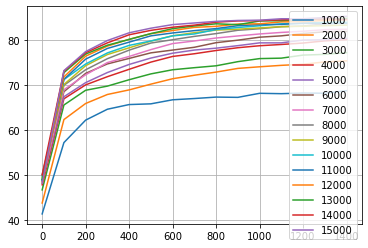

In [71]:
values = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400] 
df = pd.DataFrame(test_error) #test accuracy
df.index = values
plt.plot(df, label=df.columns)
plt.legend()
plt.grid(True)

## RGB Images

In [72]:
test_error={}
# typo!!
# this dictionary stores the test accuracy
for i in range(1000,15001,1000):
    n_epoch = 1500
    minibatch_size = 5 
    N = i  
    img_indices = np.arange(N)
    beta = np.copy(beta_init_rgb)
    learning_rate = 0.000000005
    indices=random.sample(range(0,15000),i)
    train_set=X_train_rgb[indices]
    train_res=Y_train[indices]
    for epoch in range(n_epoch):
        n_minibatch = N // minibatch_size + 1 
        np.random.shuffle(img_indices)
    
        for k in range(n_minibatch):
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_set[batch_indices]
            Y_minibatch = train_res[batch_indices]

            val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

            beta = beta - learning_rate*grad
    
        if epoch % 100 == 0:
            err_val= 100*compute_error_rate(beta, X_test_rgb, Y_test)
            
            if i in test_error:
                test_error[i].append(err_val)
            else:
                test_error[i]=[err_val]
            print(f"epoch:{epoch} \t error(val):{err_val:2.1f}%")
            # error(val) should be accuracy(val)

epoch:0 	 error(val):52.1%
epoch:100 	 error(val):69.3%
epoch:200 	 error(val):71.8%
epoch:300 	 error(val):73.6%
epoch:400 	 error(val):74.5%
epoch:500 	 error(val):75.2%
epoch:600 	 error(val):75.4%
epoch:700 	 error(val):75.9%
epoch:800 	 error(val):76.5%
epoch:900 	 error(val):76.7%
epoch:1000 	 error(val):77.3%
epoch:1100 	 error(val):77.2%
epoch:1200 	 error(val):77.6%
epoch:1300 	 error(val):77.8%
epoch:1400 	 error(val):77.8%
epoch:0 	 error(val):54.6%
epoch:100 	 error(val):72.4%
epoch:200 	 error(val):75.1%
epoch:300 	 error(val):76.9%
epoch:400 	 error(val):77.9%
epoch:500 	 error(val):78.7%
epoch:600 	 error(val):79.3%
epoch:700 	 error(val):79.9%
epoch:800 	 error(val):80.1%
epoch:900 	 error(val):80.4%
epoch:1000 	 error(val):80.3%
epoch:1100 	 error(val):80.7%
epoch:1200 	 error(val):80.7%
epoch:1300 	 error(val):81.0%
epoch:1400 	 error(val):81.1%
epoch:0 	 error(val):54.8%
epoch:100 	 error(val):73.9%
epoch:200 	 error(val):76.8%
epoch:300 	 error(val):78.9%
epoch:400 

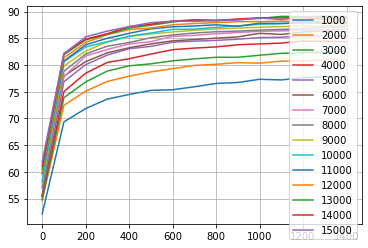

In [73]:
values = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400] 
df = pd.DataFrame(test_error) #test accuracy
df.index = values
plt.plot(df, label=df.columns)

plt.legend()
plt.grid(True)

# Specific Task 4 : Using Specific Parts of the Face (Eyes)

In [41]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
side_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

## Training Set 

In [42]:
front_face = []
side_face = []
no_face = []

is_male_front = []
is_male_side = []
is_male_no_face = []

eyes = []
no_eyes = []
more_than_two_eyes = [] 
is_male_eye = []
is_male_no_eye = []



for k in range(15000): 
    img = imageio.imread(os.path.join(path, all_img[k])) 
    faces_detected = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if faces_detected != ():
        (x, y, w, h) = faces_detected[0]
        cropped_image = img[y:y+h, x:x+w]
        eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
        front_face.append(cropped_image)
        is_male_front.append(attribute["Male"][k])

    else:
        faces_detected = side_face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
        if faces_detected != ():
            (x, y, w, h) = faces_detected[0]
            cropped_image = img[y:y+h, x:x+w]
            eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
            side_face.append(cropped_image)
            is_male_side.append(attribute["Male"][k])
        else:
            flip_img = cv2.flip(img, 1)
            faces_detected = side_face_cascade.detectMultiScale(flip_img, scaleFactor=1.1, minNeighbors=5)
            if faces_detected != ():
                (x, y, w, h) = faces_detected[0]
                cropped_image = flip_img[y:y+h, x:x+w]
                eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
                side_face.append(cropped_image)
                is_male_side.append(attribute["Male"][k])
            else:
                no_face.append(img)
                is_male_no_face.append(attribute["Male"][k])
    if eyes_detected != ():
        if len(eyes_detected) <= 2:
            for (ex, ey, ew, eh) in eyes_detected:
                eyes.append(img[y+ey:y+ey+eh, x+ex:x+ex+ew])
                is_male_eye.append(attribute["Male"][k])
        else:
            more_than_two_eyes.append([img, k])
    else:
        no_eyes.append(img)
        is_male_no_eye.append(attribute["Male"][k])

/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/2415870123.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():
/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/2415870123.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if eyes_detected != ():
/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/2415870123.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():
/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/2415870123.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():


## Test Set

In [43]:
front_face_test = []
side_face_test = []
no_face_test = []

is_male_front_test = []
is_male_side_test = []
is_male_no_face_test = []

eyes_test = []
no_eyes_test = []
more_than_two_eyes_test = [] # Contains a list [img, index] of instances that has more than 2 eyes detected

is_male_eye_test = []
is_male_no_eye_test = []



for k in range(15000,20000): ## CHANGE THIS TO NUMBER OF TRAINING!!!
    img = imageio.imread(os.path.join(path, all_img[k])) 
    faces_detected = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if faces_detected != ():
        (x, y, w, h) = faces_detected[0]
        cropped_image = img[y:y+h, x:x+w]
        eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
        front_face_test.append(cropped_image)
        is_male_front_test.append(attribute["Male"][k])

    else:
        faces_detected = side_face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
        if faces_detected != ():
            (x, y, w, h) = faces_detected[0]
            cropped_image = img[y:y+h, x:x+w]
            eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
            side_face_test.append(cropped_image)
            is_male_side_test.append(attribute["Male"][k])
        else:
            flip_img = cv2.flip(img, 1)
            faces_detected = side_face_cascade.detectMultiScale(flip_img, scaleFactor=1.1, minNeighbors=5)
            if faces_detected != ():
                (x, y, w, h) = faces_detected[0]
                cropped_image = flip_img[y:y+h, x:x+w]
                eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
                side_face_test.append(cropped_image)
                is_male_side_test.append(attribute["Male"][k])
            else:
                no_face_test.append(img)
                is_male_no_face_test.append(attribute["Male"][k])
    if eyes_detected != ():
        if len(eyes_detected) <= 2:
            for (ex, ey, ew, eh) in eyes_detected:
                eyes_test.append(img[y+ey:y+ey+eh, x+ex:x+ex+ew])
                is_male_eye_test.append(attribute["Male"][k])
        else:
            more_than_two_eyes_test.append([img, k])
    else:
        no_eyes_test.append(img)
        is_male_no_eye_test.append(attribute["Male"][k])

/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/93825918.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():
/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/93825918.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if eyes_detected != ():
/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/93825918.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():
/var/folders/cl/csfltj252gsbzqf6f1060pt00000gn/T/ipykernel_92306/93825918.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():


## Eyes

### RGB Images

In [46]:
len(eyes)

21777

In [47]:
len(eyes_test)

7244

In [91]:
n_img = len(eyes)
img_array = np.zeros((n_img, 100,100,3))
for k in range(n_img):
    im = eyes[k]
    im = resize(im, (100,100,3) )
    img_array[k,:,:,:] = im
X_train_eye=img_array.reshape(len(eyes),100*100*3)
Y_train_eye=np.asarray(is_male_eye)

In [92]:
n_img = len(eyes_test)
img_array_test = np.zeros((n_img, 100,100,3))
for k in range(n_img):
    im = eyes_test[k]
    im = resize(im, (100,100,3) )
    img_array_test[k,:,:,:] = im
X_test_eye=img_array_test.reshape(len(eyes_test),100*100*3)
Y_test_eye=np.asarray(is_male_eye_test)

In [93]:
np.random.seed(1)
beta_init_eye = np.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))

In [94]:
n_epoch = 1500
minibatch_size = 5 #size of the minibatchs
N = len(X_train_eye)  
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
train_acc=[]
test_acc=[]
beta = np.copy(beta_init_eye)
learning_rate = 0.0000005

for epoch in range(n_epoch):
    n_minibatch = N // minibatch_size + 1 
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_eye[batch_indices]
        Y_minibatch = Y_train_eye[batch_indices]

        val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

        beta = beta - learning_rate*grad

        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    
    if epoch % 100 == 0:
        err_train = 100*compute_error_rate(beta, X_train_eye, Y_train_eye)
        train_acc.append(err_train)
        err_val= 100*compute_error_rate(beta, X_test_eye, Y_test_eye)
        test_acc.append(err_val)
        print(f"epoch:{epoch} \t Loss:{np.mean(all_loss_within_epoch):2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
        # typo!!
        # error(train) should be accuracy(train)
        # error(val) should be accuracy(val)

epoch:0 	 Loss:0.658 	 error(train):61.9% 	 error(val):61.5%
epoch:100 	 Loss:0.494 	 error(train):79.2% 	 error(val):79.1%
epoch:200 	 Loss:0.457 	 error(train):80.9% 	 error(val):81.3%
epoch:300 	 Loss:0.437 	 error(train):81.7% 	 error(val):82.3%
epoch:400 	 Loss:0.425 	 error(train):82.2% 	 error(val):82.6%
epoch:500 	 Loss:0.417 	 error(train):82.5% 	 error(val):83.2%
epoch:600 	 Loss:0.410 	 error(train):82.7% 	 error(val):83.3%
epoch:700 	 Loss:0.406 	 error(train):82.9% 	 error(val):83.5%
epoch:800 	 Loss:0.402 	 error(train):83.1% 	 error(val):83.6%
epoch:900 	 Loss:0.398 	 error(train):83.3% 	 error(val):83.8%
epoch:1000 	 Loss:0.396 	 error(train):83.4% 	 error(val):83.9%
epoch:1100 	 Loss:0.393 	 error(train):83.6% 	 error(val):84.1%
epoch:1200 	 Loss:0.391 	 error(train):83.7% 	 error(val):84.3%
epoch:1300 	 Loss:0.390 	 error(train):83.7% 	 error(val):84.4%
epoch:1400 	 Loss:0.388 	 error(train):83.8% 	 error(val):84.6%


In [95]:
100*compute_error_rate(beta, X_train_eye, Y_train_eye) #train accuracy

DeviceArray(83.85378398, dtype=float64)

In [96]:
100*compute_error_rate(beta, X_test_eye, Y_test_eye) #test accuracy

DeviceArray(84.70669427, dtype=float64)

#### Loss History

Text(0.5, 0, 'Epochs')

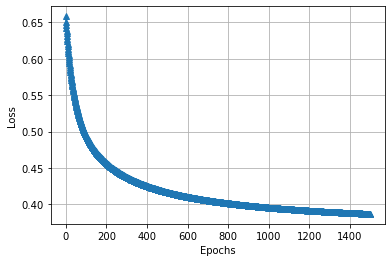

In [97]:
plt.plot(loss_history_end_epoch,"-^")
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [ ]:
jax.numpy.save("beta_eye_1500",beta) #Saved beta for ensemble model

In [119]:
beta_eye=np.load('beta_eye_1500.npy')

#### ROC Curve(AUC)

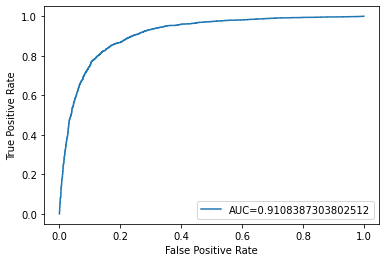

In [120]:
y_pred_proba = prediction_batch(beta_eye,X_test_eye)
fpr, tpr, _ = metrics.roc_curve(Y_test_eye, y_pred_proba)
auc = metrics.roc_auc_score(Y_test_eye, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Specific Task 6 Best Model (Front Face)

## Front Face

In [44]:
len(front_face)

14121

In [45]:
len(front_face_test)

4734

### Black and White Images 

In [36]:
n_img = len(front_face)
img_array = np.zeros((n_img, 100,100))
for k in range(n_img):
    im = front_face[k]
    im = resize(im, (100,100) )
    im = jnp.mean(im, axis=2) 
    img_array[k,:,:] = im
X_train_ff=img_array.reshape(len(front_face),100*100)
Y_train_ff=np.asarray(is_male_front)

In [37]:
n_img = len(front_face_test)
img_array_test = np.zeros((n_img, 100,100))
for k in range(len(front_face_test)):
    im = front_face_test[k]
    im = resize(im, (100,100) )
    im = jnp.mean(im, axis=2) 
    img_array_test[k,:,:] = im
X_test_ff=img_array_test.reshape(len(front_face_test),100*100)
Y_test_ff=np.asarray(is_male_front_test)

In [38]:
n_epoch = 1500
minibatch_size = 5 #size of the minibatchs
N = len(X_train_ff)  
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
test_acc=[]
train_acc=[]
beta = np.copy(beta_init_bw)
learning_rate = 0.000005
for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_ff[batch_indices]
        Y_minibatch = Y_train_ff[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    
    if epoch % 100 == 0:
        err_train = 100*compute_error_rate(beta, X_train_ff, Y_train_ff)
        train_acc.append(err_train)
        err_val= 100*compute_error_rate(beta, X_test_ff, Y_test_ff)
        test_acc.append(err_val)
        print(f"epoch:{epoch} \t Loss:{np.mean(all_loss_within_epoch):2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
        # typo!!
        # error(train) should be accuracy(train)
        # error(val) should be accuracy(val)

epoch:0 	 Loss:0.669 	 error(train):60.2% 	 error(val):60.2%
epoch:100 	 Loss:0.490 	 error(train):78.4% 	 error(val):79.3%
epoch:200 	 Loss:0.441 	 error(train):81.8% 	 error(val):82.4%
epoch:300 	 Loss:0.414 	 error(train):83.4% 	 error(val):83.7%
epoch:400 	 Loss:0.396 	 error(train):83.9% 	 error(val):84.3%
epoch:500 	 Loss:0.384 	 error(train):84.3% 	 error(val):84.9%
epoch:600 	 Loss:0.375 	 error(train):84.7% 	 error(val):85.3%
epoch:700 	 Loss:0.368 	 error(train):84.9% 	 error(val):85.6%
epoch:800 	 Loss:0.363 	 error(train):85.0% 	 error(val):85.7%
epoch:900 	 Loss:0.358 	 error(train):85.2% 	 error(val):85.9%
epoch:1000 	 Loss:0.354 	 error(train):85.3% 	 error(val):86.0%
epoch:1100 	 Loss:0.350 	 error(train):85.4% 	 error(val):86.1%
epoch:1200 	 Loss:0.348 	 error(train):85.6% 	 error(val):86.3%
epoch:1300 	 Loss:0.345 	 error(train):85.6% 	 error(val):86.4%
epoch:1400 	 Loss:0.343 	 error(train):85.7% 	 error(val):86.5%


In [39]:
100*compute_error_rate(beta, X_train_ff, Y_train_ff) #train accuracy

DeviceArray(85.91459528, dtype=float64)

In [40]:
100*compute_error_rate(beta, X_test_ff, Y_test_ff) #test accuracy

DeviceArray(86.58639628, dtype=float64)

#### Loss History

Text(0, 0.5, 'Loss')

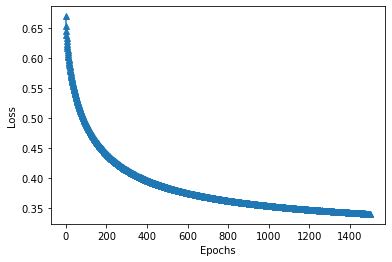

In [41]:
plt.plot(loss_history_end_epoch,"-^")
plt.xlabel("Epochs")
plt.ylabel("Loss")

#### ROC Curve(AUC)

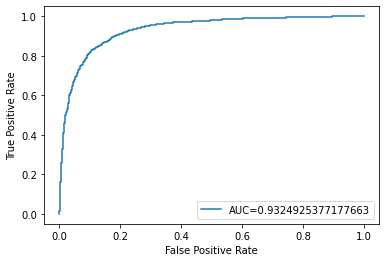

In [42]:
y_pred_proba = prediction_batch(beta,X_test_ff)
fpr, tpr, _ = metrics.roc_curve(Y_test_ff, y_pred_proba)
auc = metrics.roc_auc_score(Y_test_ff, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### RGB Images

In [43]:
n_img = len(front_face)
img_array = np.zeros((n_img, 100,100,3))
for k in range(n_img):
    im = front_face[k]
    im = resize(im, (100,100) )
    img_array[k,:,:,:] = im
X_train_ff=img_array.reshape(len(front_face),100*100*3)
Y_train_ff=np.asarray(is_male_front)

In [44]:
n_img = len(front_face_test)
img_array_test = np.zeros((n_img, 100,100,3))
for k in range(len(front_face_test)):
    im = front_face_test[k]
    im = resize(im, (100,100) )
    img_array_test[k,:,:,:] = im
X_test_ff=img_array_test.reshape(len(front_face_test),100*100*3)
Y_test_ff=np.asarray(is_male_front_test)

In [45]:
n_epoch = 1500
minibatch_size = 5 #size of the minibatchs
N = len(X_train_ff)  
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
test_acc=[]
train_acc=[]
beta = np.copy(beta_init_rgb)
learning_rate = 0.000005

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_ff[batch_indices]
        Y_minibatch = Y_train_ff[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    
    if epoch % 100 == 0:
        err_train = 100*compute_error_rate(beta, X_train_ff, Y_train_ff)
        train_acc.append(err_train)
        err_val= 100*compute_error_rate(beta, X_test_ff, Y_test_ff)
        test_acc.append(err_val)
        print(f"epoch:{epoch} \t Loss:{np.mean(all_loss_within_epoch):2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
        # typo!!
        # error(train) should be accuracy(train)
        # error(val) should be accuracy(val)

epoch:0 	 Loss:0.666 	 error(train):61.4% 	 error(val):61.8%
epoch:100 	 Loss:0.374 	 error(train):85.5% 	 error(val):85.9%
epoch:200 	 Loss:0.330 	 error(train):87.4% 	 error(val):87.7%
epoch:300 	 Loss:0.308 	 error(train):88.4% 	 error(val):88.3%
epoch:400 	 Loss:0.294 	 error(train):89.0% 	 error(val):88.7%
epoch:500 	 Loss:0.285 	 error(train):89.2% 	 error(val):89.1%
epoch:600 	 Loss:0.277 	 error(train):89.4% 	 error(val):89.4%
epoch:700 	 Loss:0.271 	 error(train):89.6% 	 error(val):89.5%
epoch:800 	 Loss:0.266 	 error(train):89.9% 	 error(val):89.7%
epoch:900 	 Loss:0.261 	 error(train):89.9% 	 error(val):89.6%
epoch:1000 	 Loss:0.257 	 error(train):90.2% 	 error(val):89.9%
epoch:1100 	 Loss:0.254 	 error(train):90.3% 	 error(val):89.9%
epoch:1200 	 Loss:0.251 	 error(train):90.4% 	 error(val):90.0%
epoch:1300 	 Loss:0.248 	 error(train):90.3% 	 error(val):90.1%
epoch:1400 	 Loss:0.246 	 error(train):90.4% 	 error(val):90.1%


In [46]:
100*compute_error_rate(beta, X_train_ff, Y_train_ff) #train accuracy

DeviceArray(90.54599533, dtype=float64)

In [47]:
100*compute_error_rate(beta, X_test_ff, Y_test_ff) #test accuracy 

DeviceArray(90.0295733, dtype=float64)

#### Loss History

Text(0, 0.5, 'Loss')

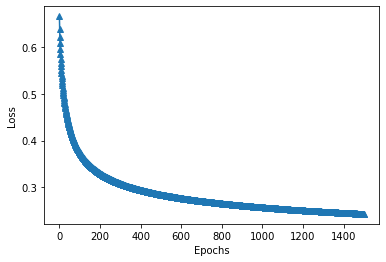

In [48]:
plt.plot(loss_history_end_epoch,"-^")
plt.xlabel("Epochs")
plt.ylabel("Loss")

#### ROC Curve (AUC)

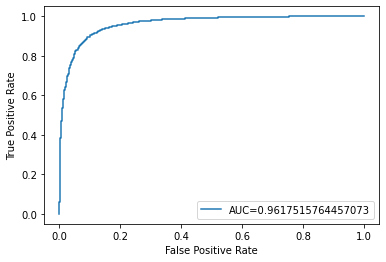

In [49]:
y_pred_proba = prediction_batch(beta,X_test_ff)
fpr, tpr, _ = metrics.roc_curve(Y_test_ff, y_pred_proba)
auc = metrics.roc_auc_score(Y_test_ff, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()